# Aerial Project & AutoML

### Requirements / Installation

In [ ]:
!pip install autosklearn

In [1]:
import csv
import platform
import shutil
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import decomposition, model_selection, naive_bayes, pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils.estimator_checks import check_estimator
from autosklearn import classification
from sklearn.metrics import accuracy_score

In [37]:
print('autosklearn: %s' % autosklearn.__version__)

autosklearn: 0.15.0


In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

%load_ext autoreload
%autoreload 2

0.24.2


In [4]:
DATA_PATH = Path("/home/ubuntu/public_data")

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid", "test"]
ALL_SETS = ["train", "valid-lab", "valid", "test"]

TORCH_MODEL = Path("torch/model")

## Step 1: Exploratory data analysis

We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.

**<span style="color:red">Warning</span>**

*In case you want to load the full data*

Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

### Load data

In [5]:
def number_lines(fname):
    with open(fname) as f:
        return sum(1 for l in f)

In [6]:
def fast_import(arr, fpath):
    with open(fpath) as f:
        for i, row in enumerate(csv.reader(f, delimiter=" ")):
            arr[i] = row

In [7]:
num_fts = number_lines(DATA_PATH / f"{DATA_NAME}_feat.name")

num = {
    data_set: number_lines(DATA_PATH / f"{DATA_NAME}_{data_set}.data")
    for data_set in DATA_SETS
}

xs_raw = {
    data_set: np.empty((num[data_set], num_fts))
    for data_set in DATA_SETS
}

for data_set in DATA_SETS:
    fast_import(
        xs_raw[data_set], 
        fpath=DATA_PATH / f"{DATA_NAME}_{data_set}.data"
    )

In [8]:
labels_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_label.name", header=None, names=["name"]
)

labels = labels_df.name.to_list()

ys_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_train.solution", header=None, names=["value"]
)

ys_raw = ys_df.values.squeeze()

ys_df["label"] = ys_df.value.map(labels_df.name)

ys_df

,value,label
0,5,island
1,0,beach
2,0,beach
3,1,chaparral
4,0,beach
...,...,...
5195,10,sea
5196,0,beach
5197,1,chaparral
5198,7,meadow


### Visualize dataset sample

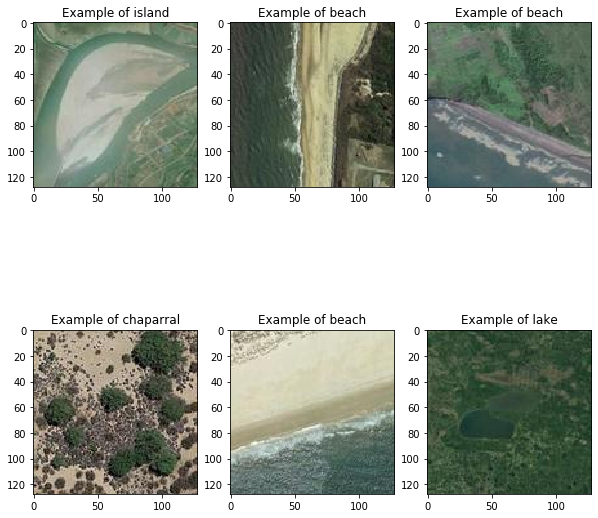

In [10]:
NUM_TO_SHOW = 6

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

for i in range(NUM_TO_SHOW):
    img = xs_raw["train"][i].reshape(128, 128, -1)
    label = ys_df.label[i]
    axs[i].set_title(f"Example of {label}")
    axs[i].imshow(img / 255)

plt.show()

## Step 2 : Building a predictive model

### Baseline model

In [11]:
print(xs_raw["train"].shape, ys_raw.shape, "\n")


xs, ys = {}, {}
(
    xs["train"],
    xs["valid-lab"],
    ys["train"],
    ys["valid-lab"],
) = model_selection.train_test_split(
    xs_raw["train"], ys_raw, test_size=0.2, random_state=123
)

xs["test"], xs["valid"] = xs_raw["test"], xs_raw["valid"]


print(xs["train"].shape, ys["train"].shape)
print(xs["valid-lab"].shape, ys["valid-lab"].shape)
print(xs["valid"].shape)
print(xs["test"].shape)

(5200, 49152) (5200,) 

(4160, 49152) (4160,)
(1040, 49152) (1040,)
(1950, 49152)
(1950, 49152)


In [12]:
N_COMP = 40  # 300 1000

scaler = StandardScaler()
pca = decomposition.PCA(n_components=N_COMP)

preproc_pipe = pipeline.Pipeline(steps=[("scaler", scaler), ("pca", pca)])  

preproc_pipe.fit(xs["train"])

xps = {
    data_set: preproc_pipe.transform(xs[data_set]) 
    for data_set in ALL_SETS
}


print(xps["train"].shape, ys["train"].shape)
print(xps["valid-lab"].shape, ys["valid-lab"].shape)
print(xps["test"].shape)

(4160, 40) (4160,)
(1040, 40) (1040,)
(1950, 40)


In [13]:
print(pca.explained_variance_ratio_.shape)
print(f"{pca.explained_variance_ratio_.cumsum()[-1]:.3f}")

(40,)
0.797


In [18]:
from autosklearn import classification
print('autosklearn: %s' % autosklearn.__version__)

autosklearn: 0.15.0


In [28]:
model = classification.AutoSklearnClassifier()
model.fit(xps["train"], ys["train"])

[WARNING] [2022-12-05 13:46:34,787:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-05 13:46:36,137:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-05 13:46:38,056:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2022-12-05 13:46:39,294:Client-EnsembleBuilder] No runs were available to build an ensemble from


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=360)

In [29]:
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: 33be9488-74a3-11ed-afb2-2fb43866b791
  Metric: accuracy
  Best validation score: 0.633649
  Number of target algorithm runs: 319
  Number of successful target algorithm runs: 229
  Number of crashed target algorithm runs: 39
  Number of target algorithms that exceeded the time limit: 2
  Number of target algorithms that exceeded the memory limit: 49



In [31]:
y_hat = model.predict(xps['valid-lab'])
acc = accuracy_score(ys['valid-lab'], y_hat)
print("Accuracy: %.3f" % acc)

Accuracy: 0.621


In [32]:
model.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
291,1,0.04,random_forest,0.366351,8.579438
245,2,0.10,random_forest,0.368536,8.651601
276,3,0.04,random_forest,0.368536,12.447568
188,4,0.08,random_forest,0.371449,9.916541
208,5,0.06,random_forest,0.372178,5.039222
285,6,0.04,random_forest,0.373634,8.641905
260,7,0.02,random_forest,0.374363,8.888058
101,8,0.14,random_forest,0.375091,9.510094
248,9,0.04,random_forest,0.375819,14.981305


In [36]:
mod = model.show_models()
pd.DataFrame.from_dict(mod, orient = 'index')

,model_id,rank,cost,ensemble_weight,data_preprocessor,balancing,feature_preprocessor,classifier,sklearn_classifier
101,101,1,0.375091,0.14,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
106,106,2,0.382374,0.04,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
132,132,3,0.376548,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
188,188,4,0.371449,0.08,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
199,199,5,0.379461,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=2, min_sa..."
208,208,6,0.372178,0.06,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(max_features=2, min_sa..."
213,213,7,0.383831,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
219,219,8,0.377276,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
228,228,9,0.383103,0.10,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
231,231,10,0.384559,0.02,<autosklearn.pipeline.components.data_preproce...,autosklearn.pipeline Balancing Imbalanced Clas...,<autosklearn.pipeline.components.feature_prepr...,<autosklearn.pipeline.components.classificatio...,"(DecisionTreeClassifier(criterion='entropy', m..."
